In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import statsmodels.api as sm

In [2]:
# reading in COVID-19 datasets
dem_df = pd.read_csv('../data/demographics.csv')
eco_df = pd.read_csv('../data/economy.csv')
epi_df = pd.read_csv('../data/epidemiology.csv')
vac_df = pd.read_csv('../data/vaccinations.csv')
idx_df = pd.read_csv('../data/index.csv')

In [3]:
us_epi_df = epi_df.loc[epi_df['location_key'] == 'US']
us_vac_df = vac_df.loc[vac_df['location_key'] == 'US']
us_ev_df = us_epi_df.merge(us_vac_df, on='date', how='inner')
us_ev_df

,date,location_key_x,new_confirmed,new_deceased,new_recovered,new_tested,cumulative_confirmed,cumulative_deceased,cumulative_recovered,cumulative_tested,...,new_persons_fully_vaccinated_janssen,cumulative_persons_fully_vaccinated_janssen,new_vaccine_doses_administered_janssen,cumulative_vaccine_doses_administered_janssen,new_persons_vaccinated_sinovac,total_persons_vaccinated_sinovac,new_persons_fully_vaccinated_sinovac,total_persons_fully_vaccinated_sinovac,new_vaccine_doses_administered_sinovac,total_vaccine_doses_administered_sinovac
0,2020-12-13,US,177830.0,2021.0,NaN,1495092.0,16119805.0,287276.0,NaN,228772064.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-14,US,195630.0,1996.0,NaN,1946701.0,16315435.0,289272.0,NaN,230718765.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-12-15,US,197440.0,2724.0,NaN,2078178.0,16512875.0,291996.0,NaN,232796943.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-12-16,US,237037.0,3374.0,NaN,2053475.0,16749912.0,295370.0,NaN,234850418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-12-17,US,242528.0,3316.0,NaN,2022937.0,16992440.0,298686.0,NaN,236873355.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,2022-09-10,US,19715.0,51.0,NaN,NaN,92225201.0,1003766.0,NaN,NaN,...,0.0,17094523.0,0.0,18881650.0,NaN,NaN,NaN,NaN,NaN,NaN
637,2022-09-11,US,16742.0,10.0,NaN,NaN,92241943.0,1003776.0,NaN,NaN,...,0.0,17094523.0,0.0,18881650.0,NaN,NaN,NaN,NaN,NaN,NaN
638,2022-09-12,US,60728.0,213.0,NaN,NaN,92302671.0,1003989.0,NaN,NaN,...,0.0,17094523.0,0.0,18881650.0,NaN,NaN,NaN,NaN,NaN,NaN
639,2022-09-13,US,54413.0,460.0,NaN,NaN,92357092.0,1004449.0,NaN,NaN,...,0.0,17094523.0,0.0,18881650.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# convert data to sliding window

cases = pd.DataFrame(us_ev_df['new_confirmed'])
cols = list()
cols.append(cases.shift(1))
cols.append(cases)
cases_new = pd.concat(cols, axis=1)
cases_new = cases_new.set_axis(['before', 'after'], axis=1)
cases_new = cases_new.tail(-1)
cases_sw = np.array(cases_new)
cases_new

,before,after
1,177830.0,195630.0
2,195630.0,197440.0
3,197440.0,237037.0
4,237037.0,242528.0
5,242528.0,233736.0
...,...,...
636,81861.0,19715.0
637,19715.0,16742.0
638,16742.0,60728.0
639,60728.0,54413.0


In [9]:
def Poisson(X, Y, stepSize, rho):

    theta = [0.1]
    its = 0

    while True:

        thetaPrime = ComputeGrad(X, Y, theta)

        if np.linalg.norm(thetaPrime) < rho:
            return theta

        if its % 1000 == 0:
            stepSize = stepSize / 10


        theta = theta + stepSize*thetaPrime

        its += 1

    return

def ComputeLikelihood(X, Y, theta):

    logLikelihood = 0

    # For all data points,
    for i in range(len(X)):

        logLikelihood += (np.dot(theta, X[i]) * Y[i]) - np.exp(np.dot(theta, X[i]))



    return logLikelihood


def ComputeGrad(X, Y, theta):

    gradient = 0



    # For all data points,
    for i in range(len(X)):
        #print("Gradient", gradient)

        tx = np.dot(theta, X[i])

        gradient += Y[i]*X[i] - X[i]*np.exp(tx)


    return gradient

def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [8]:
theta = [1,1,1]

poisson_vals = list()


X = cases_sw[:, :-1] / 1000000
Y = cases_sw[:, -1] / 1000000

print(Poisson(X, Y, 1, 0.000001))

print(sm.GLM(Y, X, family=sm.families.Poisson()).fit().summary())

[-8.50965958]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  640
Model:                            GLM   Df Residuals:                      639
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -464.87
Date:                Fri, 28 Apr 2023   Deviance:                       582.80
Time:                        14:50:24   Pearson chi2:                 3.44e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             -1.227
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -8.5097      0.684    -1

In [12]:
def Test(X, Y, model):

    testingAccuracy = 0

    for i in range(len(X)):

        predicted = np.exp(X[i]*model)
        actual = Y[i]
        testingAccuracy += (actual - predicted)**2

    return testingAccuracy

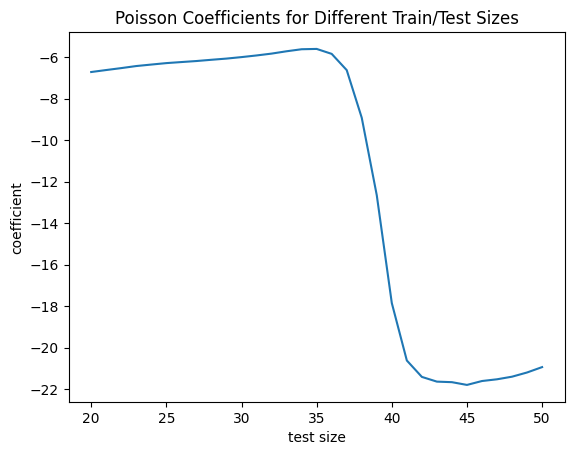

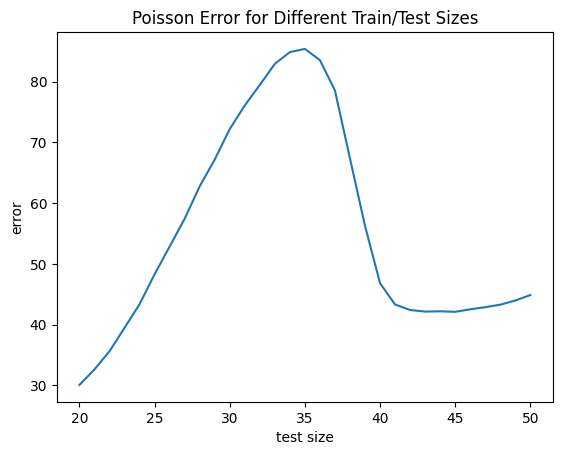

In [14]:
pois_vals = list()
pois_acc = list()
for i in range(31):
    train, test = train_test_split(cases_sw, int((0.2+i/100) * len(cases_sw)))
    train = train / 1000000
    test = test / 1000000
    pois = Poisson(train[:, :-1], train[:, -1], 1, 0.000001)
    pois_vals.append(pois)
    pois_acc.append(Test(test[:, :-1], test[:, -1], pois))

plt.plot(range(20, 51, 1), pois_vals)
plt.xlabel('test size')
plt.ylabel('coefficient')
plt.title('Poisson Coefficients for Different Train/Test Sizes')
plt.show()

plt.plot(range(20, 51, 1), pois_acc)
plt.xlabel('test size')
plt.ylabel('error')
plt.title('Poisson Error for Different Train/Test Sizes')
plt.show()